## Problem Statement

Krittika's Python tutorial notebooks: https://github.com/krittikaiitb/tutorials <br><br>
A Cepheid variable is a type of star that, due to some inherent instability, pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. As it turns out, the period of pulsation and the Luminosity (i.e the absolute magnitude) of the Cephied are related. <br><br>
We'll use data of cepheids from the Small Magallenic Cloud (SMC) obtained by a survey called Optical Gravitational Lensing Experiment (OGLE).The Small Magellanic Cloud is a dwarf galaxy satellite of the Milky Way, and distances to any star in it can be assumed to be almost constant. So the magnitudes translated directly into absolute magnitudes with some offset dependent on the distance to the SMC!

### Data Cleaning

The data file given consists of 'ID', the identifier for the star; 'RA', the right ascension in HMS format; 'Decl', the declination in DMS format; 'I' , the I band magnitude; 'V', the V band magnitude; 'P_1', the period. <br><br>
Some entries in the V and I band magnitude have a value of -99.990, so we do not want to use these stars for further analysis. Remove such entries. Further, convert the RA and Dec values to degrees from HMS and DMS respectively. You might find Pandas convenient for the above purposes.

In [1]:
import pandas as pd

cepheid = pd.read_csv("CepheidData.csv")
cepheid.drop(cepheid.index[cepheid['V'] == -99.990], inplace = True)    #removes the entries with V band magnitude values of -99.990
cepheid.drop(cepheid.index[cepheid['I'] == -99.990], inplace = True)    #removes the entries with I band magnitude values of -99.990

cepheid["RA"] = cepheid.RA.str.split(':')
cepheid["RA"] = cepheid.RA.apply(lambda i : 15*(int(i[0]) + int(i[1])/60 + float(i[2])/3600))
#converts Right Ascension angle from HMS to Degrees

cepheid["Decl"] = cepheid.Decl.str.split(':')
cepheid["Decl"] = cepheid.Decl.apply(lambda i : int(i[0]) + int(i[1])/60 + float(i[2])/3600)
#converts Declination angle from DMS to Degrees

cepheid = cepheid[cepheid["RA"] <= 60]    #to remove the three rows with anomalous values in RA coulumn

Plot the RA, Dec coordinates in a sky grid using Matplotlib. (Hint: Look up Mollweide projections in Matplotlib)

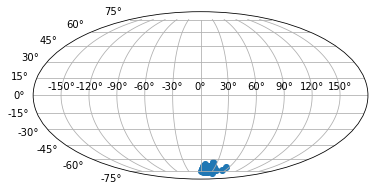

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.subplot(projection="mollweide")
plt.grid(True)
plt.scatter(cepheid["RA"]*np.pi/180, cepheid["Decl"]*np.pi/180)
#mollweide requires the units to be in radians, hence the conversion from degrees

plt.show()

### P-L Diagrams

Plot the Magnitude vs log(Period) for V and I bands. Observe that a linear fit can be done to obtain the period magnitude relation for each band separately. Use scipy's curve fit module to obtain the relation for both V and I band. The P-L relation is of the form <br><br>
$m_{\lambda} = a_{\lambda}log(P) + I_{\lambda}$ <br><br>
where $m_{\lambda}$ is the apparent magnitude, $a_{\lambda}$ is the slope, P is period and $I_{\lambda}$ is the intercept

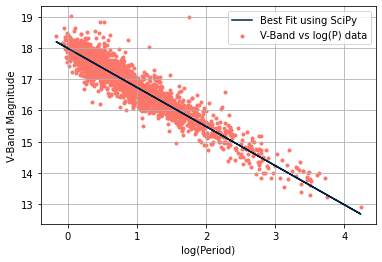

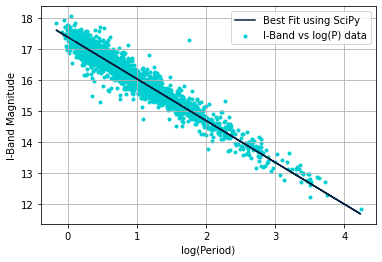

In [3]:
from scipy.optimize import curve_fit as cfit

def func(x, a, i):
    return a*x + i
#In the above function, 'x' represents log(P), 'a' represents the slope 𝑎_𝜆, and 'i' represents the intercept I_𝜆

#V band magnitude vs log(Period) plot
plt.scatter(np.log(cepheid["P_1"]), cepheid["V"], marker = '.', color = '#FC766AFF')
plt.xlabel("log(Period)")
plt.ylabel("V-Band Magnitude")
plt.grid(True)

#best fit line from scipy's curve_fit module
param_V, param_V_cov = cfit(func, np.log(cepheid["P_1"]), cepheid["V"])
plt.plot(np.log(cepheid["P_1"]), func(np.log(cepheid["P_1"]), param_V[0], param_V[1]), color = '#00203FFF')

plt.legend(['Best Fit using SciPy', 'V-Band vs log(P) data'])
plt.show()


#I band magnitude vs log(Period) plot
plt.scatter(np.log(cepheid["P_1"]), cepheid["I"], marker = '.', color = 'darkturquoise')
plt.xlabel("log(Period)")
plt.ylabel("I-Band Magnitude")
plt.grid(True)

#best fit line from scipy's curve_fit module
param_I, param_I_cov = cfit(func, np.log(cepheid["P_1"]), cepheid["I"])
plt.plot(np.log(cepheid["P_1"]), func(np.log(cepheid["P_1"]), param_I[0], param_I[1]), color = '#00203FFF')

plt.legend(['Best Fit using SciPy', 'I-Band vs log(P) data'])
plt.show()

### Deviation

From the P-L diagrams, you can observe that there are quite a few stars that deviate from the linear fit, in both bands. A naive attempt at quantifying the deviation from the P-L relation would be by splitting the region the cepheids are contained in into multiple patches and calculating the fit parameters in each patch. Assume that the change in slope value is negligible. This leaves only the intercept, implying that the new fit is a vertical offset from the global fit done earlier. <br><br>

Divide the SMC region into 25 patches. You can do this by simply partitioning the RA and Dec ranges into 5 parts each. Each patch would look somewhat similar to the reference image below (not related to SMC data). Make sure that you do not include outliers while partitioning RA and Dec. Quantiles can be used to change the range containing 5% to 95% of all entries. <br><br>

![Sky Grid](Sky_Grid.png)

Write a function to perform a linear fit to both V and I bands in each patch and return the intercept values. We calculate the deviation as <br><br>

$D_{V-I} = (GI_V - I_V) - (GI_I - I_I)$ <br><br>

where GI is the Grid Intercept (intercept values in each grid) and I is the intercept (global intercept from the previous part). The bands are in given in the subscripts. You will obtain 25 values of $D_{V-I}$, one for each patch. Plot a histogram of these values.

In [4]:
q_RA_low = cepheid["RA"].quantile(0.05)
q_RA_high = cepheid["RA"].quantile(0.95)

q_Decl_low = cepheid["Decl"].quantile(0.05)
q_Decl_high = cepheid["Decl"].quantile(0.95)

cep_filt = cepheid[(cepheid["RA"] > q_RA_low) & (cepheid["RA"] < q_RA_high) & (cepheid["Decl"] > q_Decl_low) & (cepheid["Decl"] < q_Decl_high)]
#Outliers rejected in the filtered data 'cep_filt'

print('Max value in RA = ', cep_filt.RA.max())
print('Min value in RA = ', cep_filt.RA.min())
print('Max value in Decl = ', cep_filt.Decl.max())
print('Min value in Decl = ', cep_filt.Decl.min())

Max value in RA =  18.617958333333334
Min value in RA =  8.761541666666668
Max value in Decl =  -70.28738888888888
Min value in Decl =  -73.48183333333334


Rounding off the _max_ and _min_ values of RA and Decl angles obtained from the filtered data, the 5 partitions in each of RA and Decl are:

[8.7,10.7], [10.7,12.7], [12.7,14.7], [14.7,16.7], [16.7,18.7] for **Right Ascension**\
[-73.50,-72.85], [-72.85,-72.20], [-72.20,-71.55], [-71.55,-70.90], [-70.90,-70.25] for **Declination**

In [5]:
GI_V = param_V[1]
GI_I = param_I[1]
#the global intercepts obtained from the code cell below P-L Diagrams problem statement

M_V = param_V[0]
M_I = param_I[0]
#the above two values are the slopes of the best fit lines of V-band vs log(P) and I-band vs log(P) plots respectively


#test function for determining the best fit line of V-band vs log(P) using scipy's curve_fit module
def func_V(x, c):
    return M_V*x + c

#test function for determining the best fit line of I-band vs log(P) using scipy's curve_fit module
def func_I(x, c):
    return M_I*x + c

#function which returns the deviation for a particular patch
def dev(patch_RA, patch_Decl):
    df = cep_filt[(cep_filt["RA"] >= patch_RA[0]) & (cep_filt["RA"] <= patch_RA[1]) & (cep_filt["Decl"] >= patch_Decl[0]) & (cep_filt["Decl"] <= patch_Decl[1])]
    if df.size == 0:
        return 'null' 
    
    else:
        I_V, I_V_cov = cfit(func_V, np.log(df["P_1"]), df["V"])
        I_I, I_I_cov = cfit(func_I, np.log(df["P_1"]), df["I"])
    
        return (GI_V - I_V[0]) - (GI_I - I_I[0])


#Arrays containing 5 patches each for RA and Declination
ra_arr = np.array([[8.7,10.7], [10.7,12.7], [12.7,14.7], [14.7,16.7], [16.7,18.7]])
decl_arr = np.array([[-73.50,-72.85], [-72.85,-72.20], [-72.20,-71.55], [-71.55,-70.90], [-70.90,-70.25]])

dev_arr = []

for i in range(5):
    for j in range(5):
        d = dev(ra_arr[i], decl_arr[j])
        if d != 'null':
            dev_arr.append(d)

print('Max value in dev_arr is: ', max(dev_arr))
print('Min value in dev_arr is: ', min(dev_arr))

Max value in dev_arr is:  0.07245686773724103
Min value in dev_arr is:  -0.05939568847618659


C:\Users\shrey\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


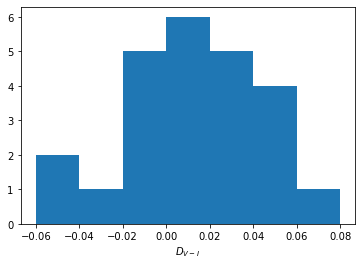

In [6]:
#Based on the max and min values of the deviations, let the bins for the histogram be
bins = [-0.06, -0.04, -0.02, -0., 0.02, 0.04, 0.06, 0.08]

plt.hist(dev_arr, bins)
plt.xlabel('$D_{V-I}$')
plt.show()

### Wesenheit Index

Deviations from P-L relation may occur due to a phenomena called interstellar extinction. The Wesenheit Index, defined as `W = I - 1.55(V - I)` automatically takes care of extinction. Show a plot of W vs log(P) for the given data.

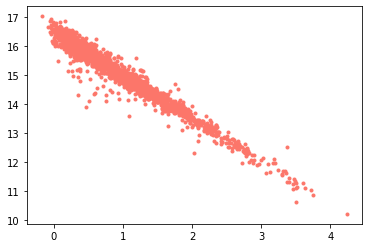

In [7]:
plt.scatter(np.log(cepheid["P_1"]), cepheid["I"] - 1.55*(cepheid["V"] - cepheid["I"]), marker = '.', color = '#FC766AFF')
plt.show()

### Hints and References:

Magnitude system: [Wikipedia](https://en.wikipedia.org/wiki/Magnitude_(astronomy%29) <br>
Pandas: [Pandas](https://pandas.pydata.org/docs/user_guide/index.html)<br>
Interstellar Extinction: [Wikipedia](https://en.wikipedia.org/wiki/Extinction_(astronomy%29)